# Standalone Convergence Checker for the numerical vKdV solver KISSME bottom - KISSME stratification

Getting more realistic now. Using the real KISSME stratification. 

Still linear non hydrostatic
Still using an offshore 'blank' zone with initial conditions not boundary conditions

In [66]:
import xarray as xr
from iwaves.kdv.kdvimex import KdVImEx#from_netcdf
from iwaves.kdv.vkdv import vKdV 
from iwaves.kdv.solve import solve_kdv
from iwaves.utils.plot import vKdV_plot
import iwaves.utils.initial_conditions as ics

import pandas as pd
import numpy as np
from scipy.interpolate import PchipInterpolator as pchip
from scipy.interpolate import interp1d
import scipy.signal

import matplotlib.pyplot as plt

%matplotlib inline

from matplotlib import rcParams

# Set font sizes
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "14"
rcParams['axes.labelsize']='large'

# CONSTANTS FOR WHOLE NOTEBOOK
d = 252.5
L_d = 3.0e5
Nz = 100
bathy_params = [L_d/2, 60000, d, d/2]       
runtime = 4.5*86400.
runtime = 1.5*86400.
a0 = 20.
nonlinear = False
nonhydrostatic = False

kb_start = 80000


In [67]:
def get_kissme_h(dx, kb_start, start_depth=500):
    """
    kb_start is where the KISSME bathy starts - will be constant depth before that.
    dx is the depth to interpolate to.
    
    """
    
    data = pd.read_csv(r'..\..\..\..\03_CODE\GA BATHY CODES [and data]\xyz for chapter 3.txt', names=['x', 'y', 'h', 'z'])
    
    
    x = data['x'].values.tolist()
    y = data['y'].values.tolist()
    z = data['z'].values.tolist()

    x.reverse()
    y.reverse()
    z.reverse()

    x = np.array(x)
    y = np.array(y)
    z = np.array(z)

    delta_x = x - x[0]
    delta_y = y - y[0]

    horz_km = 110*np.sqrt((delta_x**2+(delta_y*np.cos(np.pi*y/180))**2))
    
    ##########
    ## OUTPUTS
    x = 1000*horz_km
    h = -z
    
    
    #########
    ## LIMIT
    
    ind = np.where(abs(h-start_depth)==min(abs(h-start_depth)))[0][0]
     
    x = x[ind:-1]
    h = h[ind:-1]
    
    x = x-x[0]+kb_start
    
    ############
    ## ADD START
    
    print(np.max(x))
    print(dx)
    xi = np.arange(-2*dx, L_d+dx, dx)
    F = interp1d(x, h, bounds_error=False, fill_value='extrapolate')
    hi = F(xi)
    
    ind = np.where(xi<kb_start)[0]
    hi[ind] = h[0]
    
    ind = np.where(xi>max(x))[0]
    hi[ind] = h[-1]

    #########
    ## FILTER
    b, a = scipy.signal.butter(4, 1/200)
    hi = scipy.signal.filtfilt(b, a, hi)
    
    return xi, hi 

def get_rho_kissme_apr3():
    
    ncfile = r'\\drive.irds.uwa.edu.au\CEME-BBLE-001\KISSME\Processed data\Moorings\Mooring-Temp-SP250_2short.nc'
    ncfile = r'./data/Mooring-Temp-SP250_2short.nc'
    ncfile = r'C:\Users\AZulberti\Dropbox\University\PhD\2016_Andrew_Zulberti_2\02 WRITING\3 - Energy dissipation/data/Mooring-Temp-SP250_2short.nc'

    # April 4
    ti_i = 3390 - 200
    ti_f = 3420 + 200

    # Apr 3
    ti_i = 1000
    ti_f = 1500

    ti_m = int(np.mean((ti_i, ti_f)))

    ti_wave = np.arange(ti_i, ti_f)
    ti_full = np.arange(ti_i-200, ti_f+200)

    ds = xr.open_dataset(ncfile)
    
    rho_opt = 'hat'
    # rho_opt = 'star'
    if rho_opt == 'hat':
        rho = ds.dens_hat.values[:, ti_m]
    elif rho_opt == 'star':
        rho = ds.dens_star.values[:, ti_m]

    z = ds.height_star.values

    rho = rho[::-1]
    z = z[::-1]

    z = z-max(z)
    
    return z, rho


In [68]:

# Functions

def run_kdv(args):
    """
    Main function for generating different soliton scenarios
    """
    rho_params, bathy_params, a0, L_d, mode, nu_H, dx, runtime, dt, Lw, solver = args
    ####################################################
    # Inputs
    mode = 0
    
    Nz = 100

    ntout = 1800.0

#     z = np.linspace(0, -d, Nz)
#     rhoz = ics.rho_double_tanh_rayson(rho_params,z)
    
    z, rhoz = get_rho_kissme_apr3()

    dz = np.abs(z[1]-z[0])

    if solver == 'vkdv':
#         h = 0*x+d
#         h = ics.depth_tanh2(bathy_params, x) 
        x, h = get_kissme_h(dx, kb_start)
        pass
    elif solver == 'imex':
        x = np.arange(-2*dx,L_d+dx,dx)
        h = None

    kdvargs = dict(\
        verbose=False,\
        a0=a0,\
        Lw=Lw,\
        mode=mode,
        dt=dt,\
        nu_H=nu_H,\
        ekdv=False,\
        wavefunc=ics.eta_fullsine,\
        #L_d = L_d,
        x=x,\
        Nsubset=10,
        nonlinear=nonlinear,
        nonhydrostatic=nonhydrostatic,
    )

    ###
#     THIS WAS COPIED FROM THE KdV VERSION. IT INITIALISES EACH vKdV 3 TIMES - QUITE SLOW. 
    ###
    
    ii=0
    #rhoz = single_tanh_rho(
    #        z, pp['rho0'][ii], pp['drho1'][ii], pp['z1'][ii], pp['h1'][ii])
    
    ######

    ## Call the vKdV run function
    mykdv, Bda = solve_kdv(rhoz, z, runtime,\
            solver=solver, h=h, ntout=ntout, outfile=None, **kdvargs)

    print('Done with dx={} and dt={}'.format(dx, dt))
    
    return mykdv, Bda

In [69]:
#betas = [1023.7, 1.12, 105, 52, 155, 43] # ~April 5
#betas = [1023.5, 1.22, 67, 55, 157, 52] # ~March 1

betas_w = [1023.8229810318612,
     0.9865506702797462,
     143.5428700089361,
     46.1265812512485,
     136.66278860120943,
     41.57014327398592] # 15 July 2016

betas_s =[1023.6834358117951,
     1.2249066117658955,
     156.78804559089772,
     53.66835548728355,
     73.14183287436342,
     40.21031777315428] # 1st April 2017

mode =0
nu_H = 0

# Going to make Lw an input for the vKdV as it will really speed things up. 
dx = 100
dt = 10

dx = 10
# x = np.arange(-2*dx,L_d+dx,dx)
# h = ics.depth_tanh2(bathy_params, x) # Intended bathy profile
x, h = get_kissme_h(50, kb_start)

z = np.linspace(0, -d, Nz)
rhoz_s = ics.rho_double_tanh_rayson(betas_s, z)
Lw_s = ics.get_Lw(rhoz_s, z, z0=max(h), mode=0)

print(Lw_w)
print(Lw_s)


234499.58941895614
50
79792.58612121233
77557.02052689707


In [72]:

dxs = [800, 400, 200, 100, 50] # Note this is not necessary, it is set by the KISSME bathy currently.
# dxs = [100] # Note this is not necessary, it is set by the KISSME bathy currently.
dt = 8.

all_vkdv_dx_s = []

all_kdvimex_dx_s = []

for dx in dxs:
    
    print(' ')
    print('Running dx={}'.format(dx))
    print(' ')
    
    mykdv, B = run_kdv( (betas_s, bathy_params, a0, L_d, mode, nu_H, dx, runtime, dt, Lw_s, 'imex'))
    all_kdvimex_dx_s.append(mykdv)
    
    mykdv, B = run_kdv( (betas_s, bathy_params, a0, L_d, mode, nu_H, dx, runtime, dt, Lw_s, 'vkdv'))
    all_vkdv_dx_s.append(mykdv)
    
    print(' ')
    print('Completed dx={}'.format(dx))
    print(' ')
    

 
Running dx=800
 
Done with dx=800 and dt=8.0
234499.58941895614
800
Calculating eigenfunctions...
0.0 % complete...
25.0 % complete...
50.0 % complete...
75.0 % complete...
100.0 % complete...
Calculating nonlinear structure functions...
0.0 % complete...
25.0 % complete...
50.0 % complete...
75.0 % complete...
100.0 % complete...
Calculating buoyancy coefficients...
Done with dx=800 and dt=8.0
 
Completed dx=800
 
 
Running dx=400
 
Done with dx=400 and dt=8.0
234499.58941895614
400
Calculating eigenfunctions...
0.0 % complete...
50.0 % complete...
100.0 % complete...
Calculating nonlinear structure functions...
0.0 % complete...
50.0 % complete...
100.0 % complete...
Calculating buoyancy coefficients...
Done with dx=400 and dt=8.0
 
Completed dx=400
 
 
Running dx=200
 
Done with dx=200 and dt=8.0
234499.58941895614
200
Calculating eigenfunctions...
0.0 % complete...
25.0 % complete...
50.0 % complete...
75.0 % complete...
100.0 % complete...
Calculating nonlinear structure functio

# Just double check that vKdV used the correct bathy

234499.58941895614
50


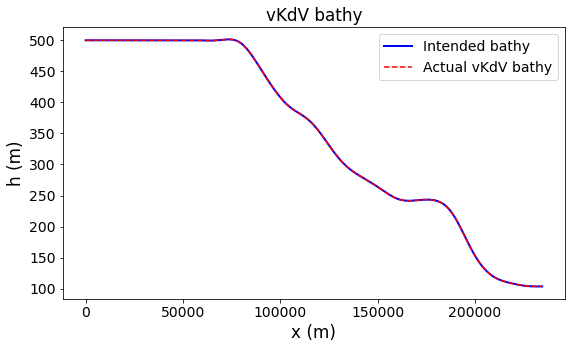

In [73]:

x, h = get_kissme_h(50, kb_start)

# h = 0*x+d
    
plt.figure(figsize=(9,5))
plt.plot(x, h, 'b', label='Intended bathy', linewidth=2)
plt.plot(all_vkdv_dx_s[-1].x, all_vkdv_dx_s[-1].h, 'r--', label='Actual vKdV bathy')
plt.ylabel('h (m)')
plt.xlabel('x (m)')
plt.title('vKdV bathy')
plt.legend()
plt.show()

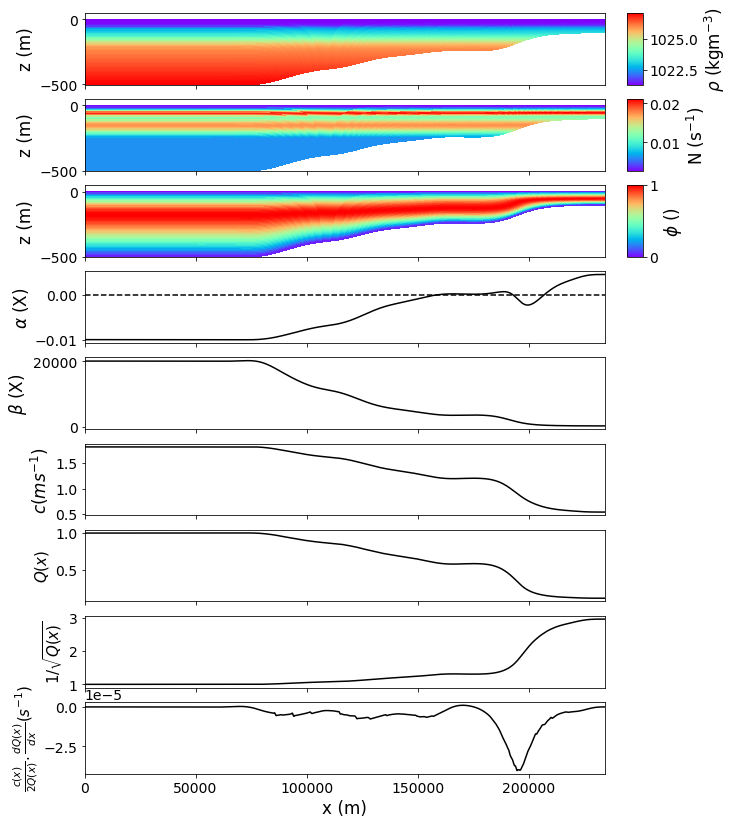

In [74]:
import importlib, iwaves
importlib.reload(iwaves.utils.plot)

from iwaves.utils.plot import vKdV_plot

f = vKdV_plot(all_vkdv_dx_s[-1])
f.savefig('Draft for ch3.png')

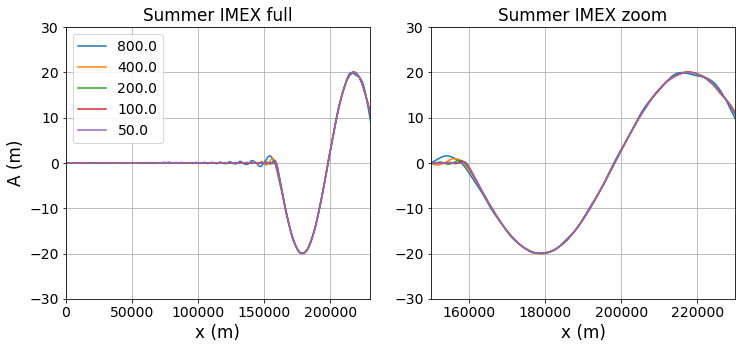

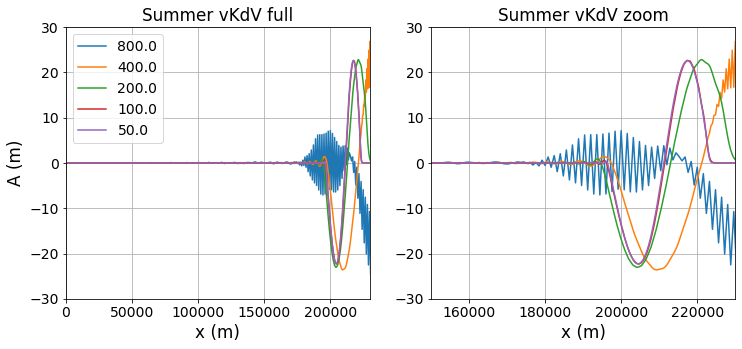

In [75]:

full_lims = (0, 230000)
zoom_lims_imex   = (150000, 230000)
zoom_lims_vkdv   = (150000, 230000)
zoom_lims_y = (-30, 30)

###########################
##### IMEX
plt.figure(figsize=(12,5))
ax=plt.subplot(121)
for mykdv in all_kdvimex_dx_s:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dx_s)
plt.xlim(full_lims)
plt.ylim(zoom_lims_y)
plt.ylabel('A (m)')
plt.xlabel('x (m)')
plt.title('Summer IMEX full')
plt.grid()
plt.legend()

ax=plt.subplot(122)
for mykdv in all_kdvimex_dx_s:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dx_s)
# plt.xlim((162200, 163600))
plt.ylim(zoom_lims_y)
plt.xlim(zoom_lims_imex)
plt.xlabel('x (m)')
plt.title('Summer IMEX zoom')
plt.grid()


###########################
##### vKdV
plt.figure(figsize=(12,5))
ax=plt.subplot(121)
for mykdv in all_vkdv_dx_s:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dx_s)
plt.xlim(full_lims)
plt.ylim(zoom_lims_y)
plt.ylabel('A (m)')
plt.xlabel('x (m)')
plt.title('Summer vKdV full')
plt.grid()
plt.legend()

ax=plt.subplot(122)
for mykdv in all_vkdv_dx_s:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dx_s)
plt.xlim(zoom_lims_vkdv)
plt.ylim(zoom_lims_y)
plt.xlabel('x (m)')
plt.title('Summer vKdV zoom')
plt.grid()

In [79]:
# Compute the errors
X = np.arange(0,L_d, 10.)
nx = X.shape[0]
ndx = len(dxs)

def get_rms_error(mykdv, nd):
    
    solns = np.zeros((nd, nx))
    for ii, mykdv in enumerate(mykdv):
        Fx = pchip(mykdv.x, mykdv.B)
        solns[ii,:] = Fx(X)

    # Compute the error between each solution
    #err = np.diff(solns, axis=0)
    err = solns - solns[-1,:]

    err_rms = np.linalg.norm(err, ord=2, axis=1) # L2-norm
    #err_rms_w = np.sqrt(np.mean(err**2,axis=1))

    return err_rms

err_rms_vkdv_s = get_rms_error(all_vkdv_dx_s, ndx)

err_rms_kdvimex_s = get_rms_error(all_kdvimex_dx_s, ndx)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\_cubic.py:288: RuntimeWarning: overflow encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\_cubic.py:288: RuntimeWarning: invalid value encountered in add
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\_cubic.py:288: RuntimeWarning: overflow encountered in add
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


<class 'numpy.float64'>
<class 'numpy.ndarray'>


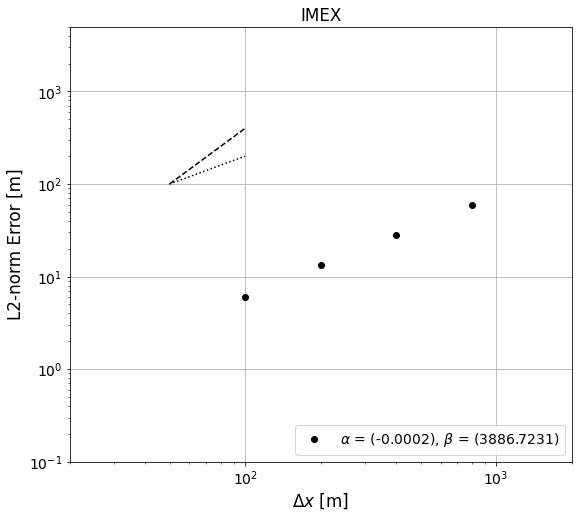

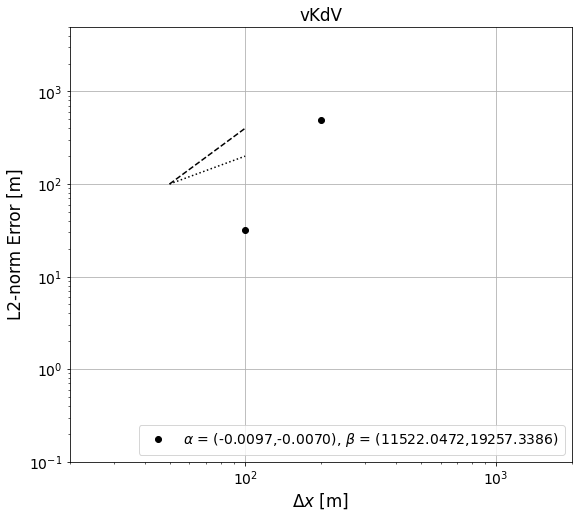

In [83]:

def make_dx_convergence_plot(kdv_s, err_s, tit):
    
    plt.figure(figsize=(9,8))
    plt.loglog(dxs[:-1],err_s[:-1],'ko')
    plt.xlim(2e1,2e3)
    plt.ylim(1e-1,5e3)
    plt.grid(b=True)
    x0 = np.array([50,100.])
    plt.plot(x0, 100/x0[0]**2*x0**2, 'k--')
    plt.plot(x0, 100/x0[0]**1*x0**1, 'k:')
    plt.ylabel('L2-norm Error [m]')
    plt.xlabel('$\Delta x$ [m]')
    plt.title(tit)
    
    alpha_s = -2*kdv_s[0].c1*kdv_s[0].r10 
    beta_s = -1*kdv_s[0].r01
    
    print(type(alpha_s)) 
    
    if not type(alpha_s) == np.float64:

        plt.legend((r'$\alpha$ = (%3.4f,%3.4f), $\beta$ = (%3.4f,%3.4f)'%(min(alpha_s), max(alpha_s), min(beta_s), max(beta_s)),
                   ), loc='lower right')
    else:
        
        plt.legend((r'$\alpha$ = (%3.4f), $\beta$ = (%3.4f)'%(alpha_s, beta_s),), loc='lower right')
    
make_dx_convergence_plot(all_kdvimex_dx_s, err_rms_kdvimex_s, 'IMEX')
make_dx_convergence_plot(all_vkdv_dx_s, err_rms_vkdv_s, 'vKdV')


In [85]:
# Delta t comparison
dts = [20,10.,5,2.5,1.25,0.6,0.3]
dx = 50.

all_vkdv_dt_w = []
all_vkdv_dt_s = []

all_kdvimex_dt_w = []
all_kdvimex_dt_s = []

for dt in dts:
    
    print(' ')
    print('Running dt={}'.format(dt))
    print(' ')
    
    mykdv, B = run_kdv( (betas_s, bathy_params, a0, L_d, mode, nu_H, dx, runtime, dt, Lw_s, 'imex'))
    all_kdvimex_dt_s.append(mykdv)
    
    mykdv, B = run_kdv( (betas_s, bathy_params, a0, L_d, mode, nu_H, dx, runtime, dt, Lw_s, 'vkdv'))
    all_vkdv_dt_s.append(mykdv)
    
    print(' ')
    print('Completed dt={}'.format(dt))
    print(' ')
    

 
Running dt=20
 
Done with dx=50.0 and dt=20
234499.58941895614
50.0
Calculating eigenfunctions...
0.0 % complete...
25.0 % complete...
50.0 % complete...
75.0 % complete...
100.0 % complete...
Calculating nonlinear structure functions...
0.0 % complete...
25.0 % complete...
50.0 % complete...
75.0 % complete...
100.0 % complete...
Calculating buoyancy coefficients...
Done with dx=50.0 and dt=20
 
Completed dt=20
 
 
Running dt=10.0
 
Done with dx=50.0 and dt=10.0
234499.58941895614
50.0
Calculating eigenfunctions...
0.0 % complete...
25.0 % complete...
50.0 % complete...
75.0 % complete...
100.0 % complete...
Calculating nonlinear structure functions...
0.0 % complete...
25.0 % complete...
50.0 % complete...
75.0 % complete...
100.0 % complete...
Calculating buoyancy coefficients...
Done with dx=50.0 and dt=10.0
 
Completed dt=10.0
 
 
Running dt=5
 
Done with dx=50.0 and dt=5
234499.58941895614
50.0
Calculating eigenfunctions...
0.0 % complete...
25.0 % complete...
50.0 % complete..

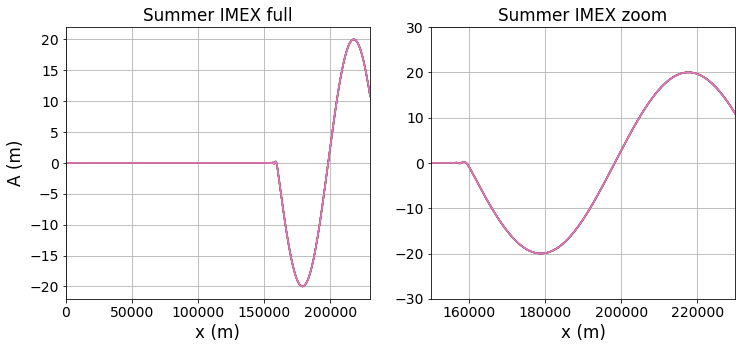

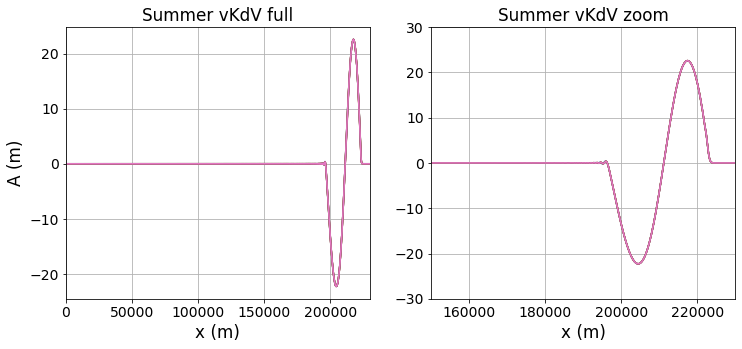

In [87]:
###########################
##### SUMMER

full_lims = (0, 230000)
zoom_lims_imex   = (150000, 230000)
zoom_lims_vkdv   = (150000, 230000)
zoom_lims_y = (-30, 30)

###########################
##### IMEX
plt.figure(figsize=(12,5))
ax=plt.subplot(121)
for mykdv in all_kdvimex_dt_s:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dt_s)
plt.ylabel('A (m)')
plt.xlabel('x (m)')
plt.title('Summer IMEX full')    
plt.xlim((full_lims))
plt.grid()

ax=plt.subplot(122)
for mykdv in all_kdvimex_dt_s:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dt_s)
    
plt.ylim(zoom_lims_y)
plt.xlim((zoom_lims_imex))
plt.xlabel('x (m)')
plt.title('Summer IMEX zoom')
plt.grid()

###########################
##### vKdV
plt.figure(figsize=(12,5))
ax=plt.subplot(121)
for mykdv in all_vkdv_dt_s:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dt_s)
plt.ylabel('A (m)')
plt.xlabel('x (m)')
plt.title('Summer vKdV full')    
plt.xlim((full_lims))
plt.grid()

ax=plt.subplot(122)
for mykdv in all_vkdv_dt_s:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dt_s)
    
plt.ylim(zoom_lims_y)
plt.xlim((zoom_lims_vkdv))
plt.xlabel('x (m)')
plt.title('Summer vKdV zoom')
plt.grid()
plt.show()


In [88]:
ndt = len(dts)

err_rms_vkdv_dt_s = get_rms_error(all_vkdv_dt_s, ndt)

err_rms_kdvimex_dt_s = get_rms_error(all_kdvimex_dt_s, ndt)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\_cubic.py:288: RuntimeWarning: overflow encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\_cubic.py:288: RuntimeWarning: overflow encountered in add
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\_cubic.py:288: RuntimeWarning: invalid value encountered in add
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


<ipython-input-91-3b71a6ddff0e>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,0.5e2)
<ipython-input-91-3b71a6ddff0e>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,0.5e2)


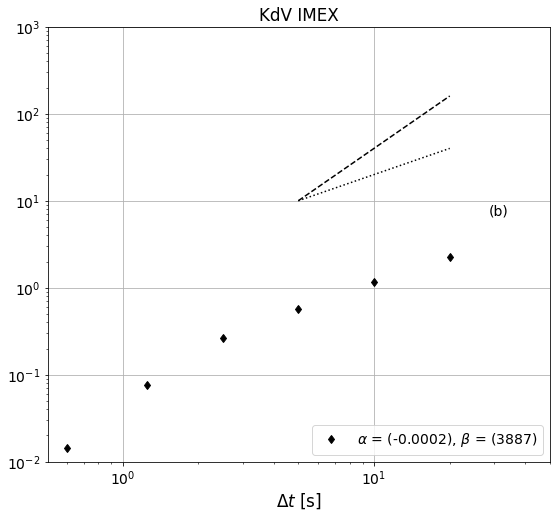

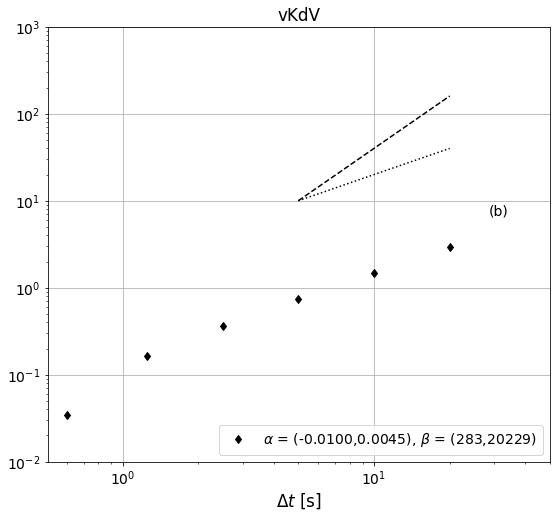

In [91]:

def make_dt_convergence_plot(kdv_s, err_s, tit):

    plt.figure(figsize=(9,8))
    plt.loglog(dts[:-1],err_s[:-1],'kd', markersize=6)
    plt.xlim(0,0.5e2)
    plt.ylim(1e-2,1e3)
    plt.grid(b=True)
    x0 = np.array([5,20])
    plt.plot(x0, 10/x0[0]**2*x0**2, 'k--')
    plt.plot(x0, 10/x0[0]**1*x0**1, 'k:')
    #plt.ylabel('L2-norm Error [m]')
    plt.xlabel('$\Delta t$ [s]')
    plt.title(tit)
    
    plt.text(0.05,0.95,'(b)',transform=ax.transAxes)
    alpha_s = -2*kdv_s[0].c1*kdv_s[0].r10 
    beta_s = -1*kdv_s[0].r01

    if not type(alpha_s) == np.float64:

        plt.legend((r'$\alpha$ = (%3.4f,%3.4f), $\beta$ = (%3.0f,%3.0f)'%(min(alpha_s), max(alpha_s), min(beta_s), max(beta_s)),
                   ), loc='lower right')
    else:
        
        plt.legend((r'$\alpha$ = (%3.4f), $\beta$ = (%3.0f)'%(alpha_s, beta_s),
                   ), loc='lower right')
        
    plt.savefig('../FIGURES/vkdv_convergence_dxdt.png',dpi=150)
    plt.savefig('../FIGURES/vkdv_convergence_dxdt.pdf',dpi=150)
    
make_dt_convergence_plot(all_kdvimex_dt_s, err_rms_kdvimex_dt_s, 'KdV IMEX')
make_dt_convergence_plot(all_vkdv_dt_s, err_rms_vkdv_dt_s, 'vKdV')
